### Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D,
    Dense, Dropout, Multiply, Reshape, Conv1D, Activation
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


2025-09-02 12:37:08.038827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756816628.379580      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756816628.470484      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data Loading

In [2]:
trainDir = '/kaggle/input/tomato-leaf-disease/train'
testDir = '/kaggle/input/tomato-leaf-disease/test'

In [3]:
# --- Training + Validation ---
trainDataset = tf.keras.utils.image_dataset_from_directory(
    trainDir,
    validation_split=0.2,
    subset="training",
    seed=123,                        # ensures reproducibility of split
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

valDataset = tf.keras.utils.image_dataset_from_directory(
    trainDir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

Found 33200 files belonging to 10 classes.
Using 26560 files for training.


I0000 00:00:1756816849.914382      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756816849.915112      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 33200 files belonging to 10 classes.
Using 6640 files for validation.


In [4]:
# Normalize (instead of rescale=1./255 in ImageDataGenerator)
normalization_layer = tf.keras.layers.Rescaling(1./255)

trainDataset = trainDataset.map(lambda x, y: (normalization_layer(x), y))
valDataset   = valDataset.map(lambda x, y: (normalization_layer(x), y))

In [5]:
# Safety: skip bad records automatically
trainDataset = trainDataset.apply(tf.data.experimental.ignore_errors())
valDataset   = valDataset.apply(tf.data.experimental.ignore_errors())

## Variation 3 – ECA Before Every IRB Stage

### Changes:

IRB: 4 stages.

ECA: Added after each IRB.

Classifier: Same as baseline.

### ECA Block

In [6]:
def eca_block(x, k_size=3):
    """
    Efficient Channel Attention (ECA).
    - Computes channel-wise attention without fully connected layers.
    - Uses 1D convolution to capture cross-channel dependencies.
    """
    channels = x.shape[-1]

    # Global Average Pooling (squeeze)
    gap = GlobalAveragePooling2D()(x)       # shape = (batch, channels)
    gap = Reshape((channels, 1))(gap)       # reshape for 1D conv

    # 1D conv to capture local channel dependencies
    conv = Conv1D(1, kernel_size=k_size, padding="same", use_bias=False)(gap)
    conv = Activation("sigmoid")(conv)

    # Reshape back and apply (excitation)
    conv = Reshape((1, 1, channels))(conv)
    out = Multiply()([x, conv])             # apply attention

    return out


### Inverted Residual Block (IRB)

In [ ]:
def inverted_residual_block(x, in_channels, out_channels, stride, expand_ratio):
    
    hidden_dim = in_channels * expand_ratio

    # 1x1 pointwise conv (expansion)
    x_exp = Conv2D(hidden_dim, kernel_size=1, padding="same", use_bias=False)(x)
    x_exp = BatchNormalization()(x_exp)
    x_exp = ReLU(6.)(x_exp)

    # 3x3 depthwise conv
    x_dw = DepthwiseConv2D(kernel_size=3, strides=stride, padding="same", use_bias=False)(x_exp)
    x_dw = BatchNormalization()(x_dw)
    x_dw = ReLU(6.)(x_dw)

    # 1x1 pointwise conv (projection)
    x_proj = Conv2D(out_channels, kernel_size=1, padding="same", use_bias=False)(x_dw)
    x_proj = BatchNormalization()(x_proj)

    return x_proj


### Model Definition

In [19]:
def build_model(input_shape=(224,224,3), num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3,3), strides=2, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)

    x = inverted_residual_block(x, 16, 16, 1, 6)
    x = eca_block(x)

    x = inverted_residual_block(x, 16, 24, 2, 6)
    x = eca_block(x)
    x = inverted_residual_block(x, 24, 24, 1, 6)
    x = eca_block(x)

    x = inverted_residual_block(x, 24, 40, 2, 6)
    x = eca_block(x)

    x = inverted_residual_block(x, 40, 96, 2, 6)
    x = eca_block(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs, name="Tomato_IRB_ECA_AllStages")


### Build

In [20]:
model = build_model(input_shape=(224,224,3), num_classes=10)

In [21]:
model.summary()

Model: "Tomato_IRB_ECA_AllStages"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │        432 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      1,536 │ re_lu_1[0][0]     │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        384 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 112, 112,  │        864 │ re_lu_2[0][0]     │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        384 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      1,536 │ re_lu_3[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 16, 1)     │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 16, 1)     │          3 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 1)     │          0 │ conv1d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1, 16)  │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 112, 112,  │          0 │ batch_normalizat

 Total params: 185,849 (725.97 KB)

 Trainable params: 182,537 (713.04 KB)

 Non-trainable params: 3,312 (12.94 KB)

### Compile Model

In [22]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [13]:
callbacks = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),
    # ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", verbose=1)
]

In [24]:
history = model.fit(
    trainDataset,
    validation_data=valDataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
    829/Unknown 93s 82ms/step - accuracy: 0.5508 - loss: 1.2642

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


829/829 ━━━━━━━━━━━━━━━━━━━━ 102s 92ms/step - accuracy: 0.5509 - loss: 1.2638 - val_accuracy: 0.5280 - val_loss: 2.0020 - learning_rate: 0.0010
Epoch 2/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 72s 87ms/step - accuracy: 0.7875 - loss: 0.6033 - val_accuracy: 0.4066 - val_loss: 2.2263 - learning_rate: 0.0010
Epoch 3/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 72s 87ms/step - accuracy: 0.8373 - loss: 0.4604 - val_accuracy: 0.6640 - val_loss: 1.1761 - learning_rate: 0.0010
Epoch 4/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 72s 87ms/step - accuracy: 0.8729 - loss: 0.3600 - val_accuracy: 0.7310 - val_loss: 0.9123 - learning_rate: 0.0010
Epoch 5/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 72s 87ms/step - accuracy: 0.8870 - loss: 0.3170 - val_accuracy: 0.8229 - val_loss: 0.5399 - learning_rate: 0.0010
Epoch 6/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 72s 87ms/step - accuracy: 0.8989 - loss: 0.2803 - val_accuracy: 0.8857 - val_loss: 0.3248 - learning_rate: 0.0010
Epoch 7/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 72s 87ms/step - accuracy: 0.9108 - loss: 0.249

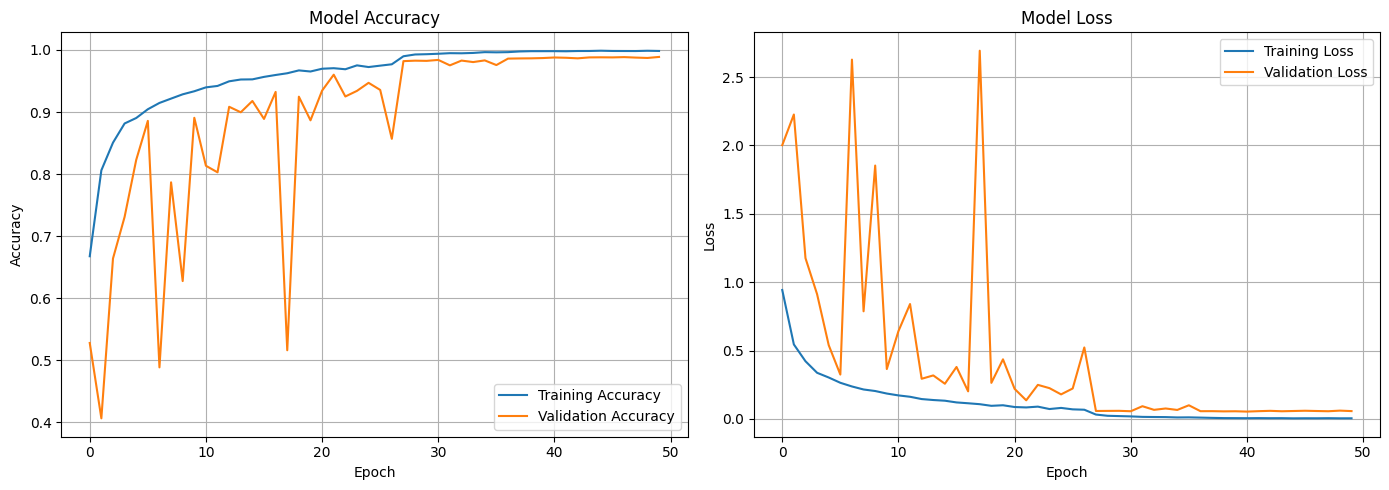

In [25]:
# Create a figure with 2 subplots
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- Accuracy plot ---
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# --- Loss plot ---
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [26]:
testDataset = tf.keras.utils.image_dataset_from_directory(
    testDir,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical",   # <-- this should give (batch, num_classes)
    shuffle=False
)
class_labels = testDataset.class_names
testDataset  = testDataset.map(lambda x, y: (normalization_layer(x), y))
testDataset  = testDataset.apply(tf.data.experimental.ignore_errors())

Found 6431 files belonging to 10 classes.


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9767 - loss: 0.1356
Test Accuracy: 0.9794
Test Loss: 0.1158
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step

Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.98      0.98      0.98       732
                        Tomato___Early_blight       0.96      0.96      0.96       643
                             Tomato___Healthy       0.98      0.99      0.99       773
                         Tomato___Late_blight       0.97      0.97      0.97       792
                           Tomato___Leaf_Mold       0.98      0.98      0.98       739
                  Tomato___Septoria_leaf_spot       0.97      0.97      0.97       746
Tomato___Spider_mites Two-spotted_spider_mite       1.00      1.00      1.00       435
                         Tomato___Target_Spot       1.00      1.00      1.00       457
       Tomato___Tomato_Yellow_Leaf

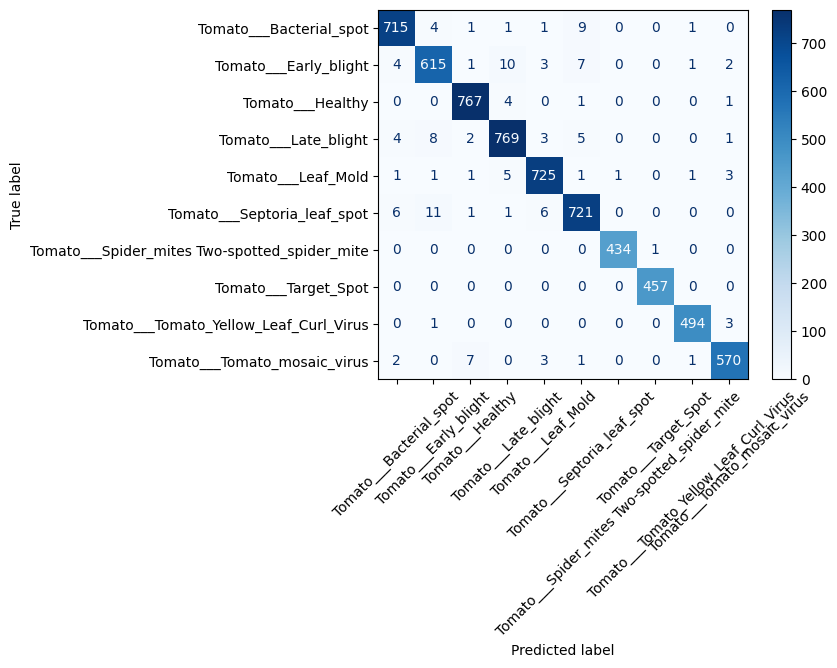

In [27]:
# -------------------------------
# Evaluate model on test dataset
# -------------------------------
loss, accuracy = model.evaluate(testDataset)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# -------------------------------
# Predictions
# -------------------------------
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(testDataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels (from testDataset)
y_true = np.concatenate([y.numpy() for x, y in testDataset], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Class labels
# class_labels = testDataset.class_names

# -------------------------------
# Classification Report
# -------------------------------
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

# -------------------------------
# Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.grid(False)
plt.show()

In [28]:
model.save('Model9.h5')